In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import random

In [2]:
from random import shuffle
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

dataset = '/content/drive/MyDrive/Colab Notebooks/Machine_Learning_AOL/Dog Emotion'

labels = os.listdir(dataset)
print(labels)

Mounted at /content/drive
['happy', 'angry', 'relaxed', 'sad']


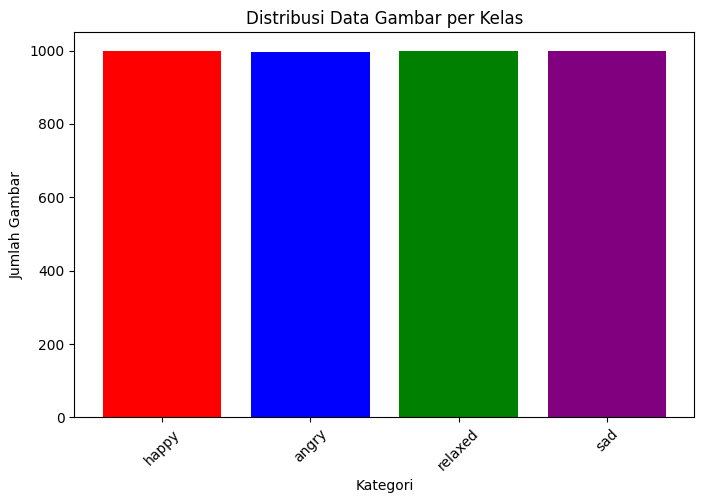

In [4]:
labels = os.listdir(dataset)

data_distribution = {label: len(os.listdir(os.path.join(dataset, label))) for label in labels}

plt.figure(figsize=(8, 5))
plt.bar(data_distribution.keys(), data_distribution.values(), color=['red', 'blue', 'green', 'purple'])
plt.xlabel("Kategori")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Data Gambar per Kelas")
plt.xticks(rotation=45)
plt.show()

### Data angry terlalu sedikit dibandingkan dengan 3 kelas lainnya, sehingga kami akan membuang data-data dikelas lain secara random

In [5]:
import os
from PIL import Image



corrupt_count = 0


for foldername, subfolders, filenames in os.walk(dataset):
    for filename in filenames:
        file_path = os.path.join(foldername, filename)
        try:
            # Coba buka file sebagai gambar
            with Image.open(file_path) as img:
                img.verify()  # Cek apakah image valid
        except (IOError, SyntaxError):
            print(f"❌ Corrupt image detected and removed: {file_path}")
            os.remove(file_path)  # Hapus file corrupt
            corrupt_count += 1

print(f"\n✅ Done. {corrupt_count} corrupt images removed.")


✅ Done. 0 corrupt images removed.


In [6]:
from pathlib import Path
import os
import imghdr

accepted_formats = ["jpeg", "png", "gif", "bmp"]
count = 0

for filepath in Path(dataset).rglob("*"):
    if filepath.is_file():
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"Deleting {filepath} (not an image)")
            os.remove(filepath)
            count += 1
        elif img_type not in accepted_formats:
            print(f"Deleting {filepath} (unsupported format: {img_type})")
            os.remove(filepath)
            count += 1

print(f"Total files deleted: {count}")

<ipython-input-6-8fb61a818e17>:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


Total files deleted: 0


setiap kelas sudah memiliki data yang sama banyak

In [7]:
!pip install tensorflow

In [8]:
import tensorflow

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
# data_augmentation = Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.2),
# ])

In [ ]:
# train_ds = tensorflow.keras.utils.image_dataset_from_directory(
#     dataset,
#     validation_split=0.3,
#     subset="training",
#     seed=42,
#     image_size=(224, 224),
#     batch_size=16
# )

# val_ds = tensorflow.keras.utils.image_dataset_from_directory(
#     dataset,
#     validation_split=0.3,
#     subset="validation",
#     seed=42,
#     image_size=(224, 224),
#     batch_size=16
# )

In [ ]:
# AUTOTUNE = tensorflow.data.AUTOTUNE

# train_ds = train_ds.map(lambda x, y: (preprocess_input(data_augmentation(x, training=True)), y))
# val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip = True
)

train_gen = train_datagen.flow_from_directory(
    directory = dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle = True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    directory = dataset,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle = True,
    subset='validation'
)

Found 2798 images belonging to 4 classes.
Found 1199 images belonging to 4 classes.


In [12]:
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze layer ResNet biar gak dilatih ulang (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
     GlobalAveragePooling2D(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=tensorflow.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [14]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 115s 557ms/step - accuracy: 0.4042 - loss: 1.7579 - val_accuracy: 0.6447 - val_loss: 0.9222
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 67s 385ms/step - accuracy: 0.6045 - loss: 1.0746 - val_accuracy: 0.6697 - val_loss: 0.8139
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 67s 383ms/step - accuracy: 0.6642 - loss: 0.8417 - val_accuracy: 0.7223 - val_loss: 0.6892
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 66s 376ms/step - accuracy: 0.7159 - loss: 0.7258 - val_accuracy: 0.7373 - val_loss: 0.6680
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 373ms/step - accuracy: 0.7580 - loss: 0.6453 - val_accuracy: 0.7398 - val_loss: 0.6883
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 370ms/step - accuracy: 0.7544 - loss: 0.6071 - val_accuracy: 0.7573 - val_loss: 0.6633
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 373ms/step - accuracy: 0.8100 - loss: 0.4965 - val_accuracy: 0.7490 - val_loss: 0.7033
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 372ms/step - accuracy: 0.8329 - loss: 

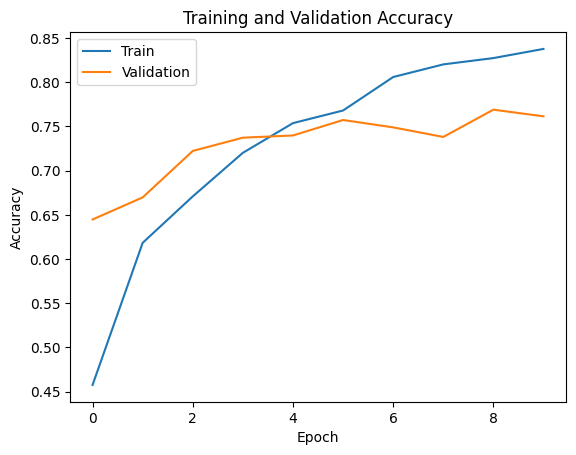

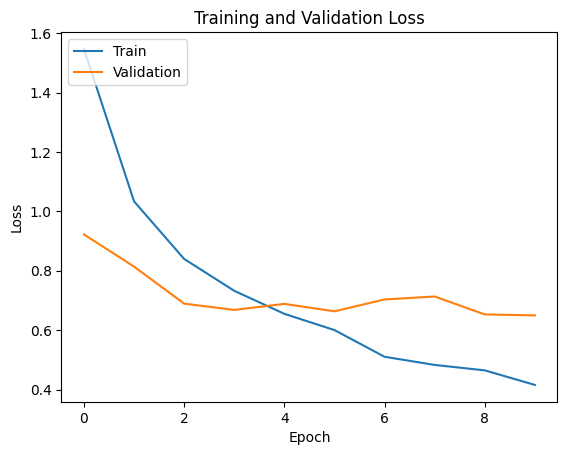

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(val_gen)

In [16]:
model.save("dog_emotion_prediction_final.keras")

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.optimizers import Adam

In [8]:
model = load_model("/content/drive/MyDrive/Colab Notebooks/Machine_Learning_AOL/dog_emotion_prediction.keras")

In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Machine_Learning_AOL/Dog Emotion/happy/2hAmgXf8tDs3PZ3AQzXpCLGMkzsb09583.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)


prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction, axis=1)


class_labels = ['angry', 'happy', 'sad', 'neutral']
predicted_label = class_labels[predicted_class_index[0]]

print("Prediksi probabilitas:", prediction)
print("Argmax:", predicted_class_index)
print("Label prediksi:", predicted_label)

EfficientNet

In [ ]:
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_v2.preprocess_input,
    validation_split=0.3,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip = True
)

train_gen = train_datagen.flow_from_directory(
    directory = data_clean,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle = True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    directory = data_clean,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle = True,
    subset='validation'
)

In [ ]:
efficient_model = efficientnet_v2.EfficientNetV2B0(  # Anda dapat memilih varian lain (B1, B2, dll.)
    input_shape=(224, 224, 3), include_top=False, weights='imagenet'
)

# Freeze semua layer base model
for layer in efficient_model.layers:
    layer.trainable = False


In [ ]:
e_model = Sequential([
    efficient_model,
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2),
    GlobalAveragePooling2D(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [ ]:
e_model.summary()

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = e_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Ensemble -> Resnet + EfficientNet

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [ ]:
def dual_input_generator(gen):
    for x, y in gen:
        yield (x, x), y  # gunakan tuple, bukan list

In [ ]:
train_dual_gen = dual_input_generator(train_gen)
val_dual_gen = dual_input_generator(val_gen)

In [ ]:
def create_model(base_model):
    x = base_model.output
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(4, activation='softmax')(x)  # 4 kelas
    return Model(inputs=base_model.input, outputs=output)

In [ ]:
resnet_base = ResNet50(include_top=False, input_shape=(224,224,3), weights='imagenet')
effnet_base = efficientnet_v2.EfficientNetV2B0(include_top=False, input_shape=(224,224,3), weights='imagenet')

for layer in resnet_base.layers:
    layer.trainable = False

for layer in effnet_base.layers:
    layer.trainable = False

In [ ]:
model_resnet = create_model(resnet_base)
model_effnet = create_model(effnet_base)

In [ ]:
ensemble_output = layers.Average()([model_resnet.output, model_effnet.output])

ensemble_model = Model(
    inputs=[model_resnet.input, model_effnet.input],
    outputs=ensemble_output
)

In [ ]:
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = ensemble_model.fit(
    train_dual_gen,
    validation_data=val_dual_gen,
    epochs=5,
    batch_size=64,
    steps_per_epoch = 100
)

Inception V3

In [ ]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3